In [1]:
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cap, Cup, Id, Ty, Word, Diagram
from lambeq import Reader, AtomicType, IQPAnsatz, BobcatParser
import numpy as np

from typing import List

In [2]:
def generate_spanish_phrases(conditions : List[str], locations : List[str]) -> List[str]:
    phrases = []
    for condition in conditions:
        for location in locations:
            phrases.append([condition, "en la", location])
    
    return phrases

def generate_english_phrases(conditions : List[str], locations : List[str]) -> List[str]:
    phrases = []
    for condition in conditions:
        for location in locations:
            phrases.append([condition, "in", location])
    
    return phrases

In [3]:
spanish_phrases = generate_spanish_phrases(["asma", "arthritis", "infección"], ["pecho", "muñeca", "oído"])
english_phrases = generate_english_phrases(["asthma", "arthritis", "infection"], ["chest", "wrist", "ear"])

In [4]:
synonymous_phrases = {
    "asma": "asthma",
    "arthritis": "arthritis",
    "infección": "infection",
    "pecho": "chest",
    "muñeca": "wrist",
    "oído": "ear",
    "en la": "in"
}

In [5]:
nounType, sentenceType = Ty('n'), Ty('s')

In [6]:
from lambeq.backend.grammar import Diagram


class ConditionSpanishReader(Reader):
    def sentence2diagram(self, sentence: str | List[str], tokenised: bool = False) -> Diagram | None:
        tokens = sentence
        if not tokenised:
            # assume input sentence is word separated by spaces
            tokens = sentence.strip().split(" ")

        words = [
            Word(tokens[0], nounType),
            Word(tokens[1], nounType.r @ nounType @ nounType.l),
            Word(tokens[2], nounType),
        ]

        cups = Cup(nounType, nounType.r) @ Id(nounType) @ Cup(nounType.l, nounType)
        return Id().tensor(*words) >> cups


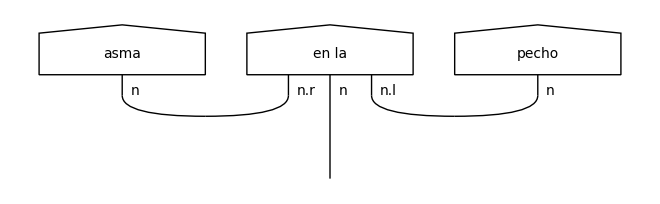

In [7]:
ConditionSpanishReader().sentence2diagram(spanish_phrases[0], tokenised=True).draw()

In [8]:
spanish_reader = ConditionSpanishReader()
english_reader = BobcatParser()

In [9]:
spanish_diagrams = [spanish_reader.sentence2diagram(phrase, tokenised=True) for phrase in spanish_phrases]
english_diagrams = [english_reader.sentence2diagram(phrase, tokenised=True) for phrase in english_phrases]

In [10]:
from pytket.extensions.qiskit import tk_to_qiskit
import copy

In [11]:
# IQP ansatz is chosen to model the ansatz from the paper
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.SENTENCE: 1}, n_layers = 2)

In [12]:
# Convert string diagram into quantum circuit using ansatz
spanish_quantum_circuits = list(map(ansatz, spanish_diagrams))
spanish_qiskit_circuits = [tk_to_qiskit(circuit.to_tk()) for circuit in spanish_quantum_circuits]

english_quantum_circuits = list(map(ansatz, english_diagrams))
english_qiskit_circuits = [tk_to_qiskit(circuit.to_tk()) for circuit in english_quantum_circuits]
randomized_qiskit_circuits = copy.deepcopy(english_qiskit_circuits)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

In [14]:
# Parametrize words
random = np.random.default_rng(seed = 42)
rotations = np.linspace(0, 1, len(spanish_qiskit_circuits) * len(spanish_qiskit_circuits[0].parameters) + 1)[:-1]
random.shuffle(rotations)

parameter_count = 0 
for circuit_index, spanish_circuit in enumerate(spanish_qiskit_circuits):
    english_circuit = english_qiskit_circuits[circuit_index]

    spanish_phrase = spanish_phrases[circuit_index]
    english_phrase = english_phrases[circuit_index]

    spanish_dict = dict()
    english_dict = dict()

    parameter_total = len(spanish_circuit.parameters)
    for spanish_parameter in spanish_circuit.parameters:
        spanish_parameter_tokens = spanish_parameter.name.split("__")

        spanish_parameter_name = f"{spanish_parameter_tokens[0]}__{spanish_parameter_tokens[-1]}"
        #english_parameter_name = f"{english_phrase[spanish_phrase.index(spanish_parameter_tokens[0])]}__{spanish_parameter_tokens[-1]}"
        english_parameter_name = f"{synonymous_phrases[spanish_parameter_tokens[0]]}__{spanish_parameter_tokens[-1]}"
        
        spanish_dict[spanish_parameter_name] = rotations[parameter_count]
        english_dict[english_parameter_name] = rotations[parameter_count]

        parameter_count += 1

    spanish_circuit.assign_parameters(spanish_dict, inplace=True)
    english_circuit.assign_parameters(english_dict, inplace=True)
    
    randomized_circuit = randomized_qiskit_circuits[circuit_index]
    randomized_rotations = random.permutation(rotations[parameter_count - parameter_total: parameter_count])
    randomized_parameter_dict = dict()
    for parameter_index, randomized_parameter in enumerate(randomized_circuit.parameters):
        randomized_parameter_dict[randomized_parameter.name] = randomized_rotations[parameter_index]

    randomized_circuit.assign_parameters(randomized_parameter_dict, inplace=True)
    

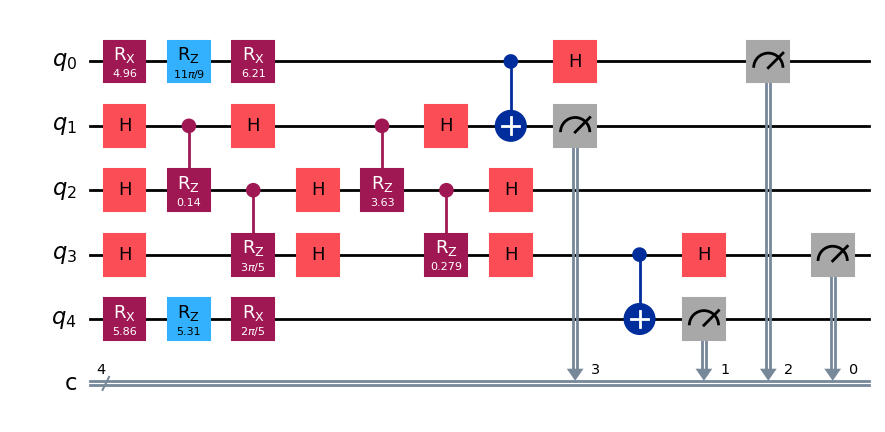

In [15]:
english_qiskit_circuits[0].draw(output="mpl")

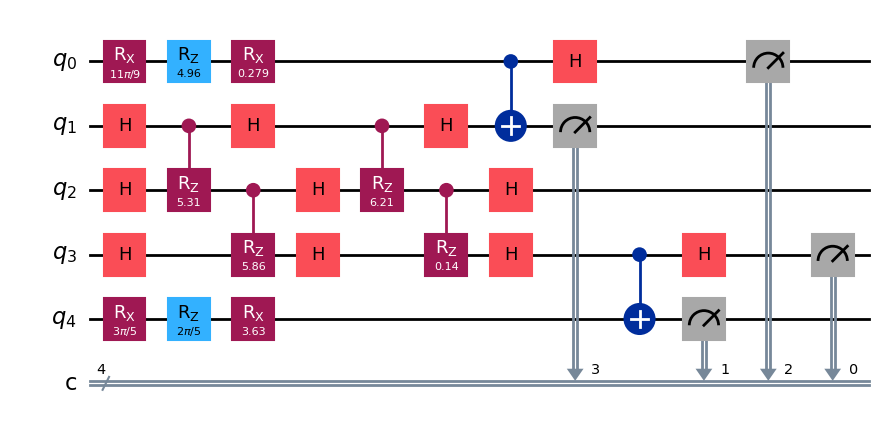

In [16]:
randomized_qiskit_circuits[0].draw(output="mpl")

In [17]:
from qiskit.visualization import plot_histogram

In [18]:
simulator = AerSimulator()
shot_count = 200000

spanish_results = []
english_results = []
randomized_results = []

for circuit_index, spanish_circuit in enumerate(spanish_qiskit_circuits):
    english_circuit = english_qiskit_circuits[circuit_index]
    randomized_circuit = randomized_qiskit_circuits[circuit_index]

    spanish_circuit = transpile(spanish_circuit, simulator)
    english_circuit = transpile(english_circuit, simulator)
    randomized_circuit = transpile(randomized_circuit, simulator)

    spanish_results.append(simulator.run(spanish_circuit, shots=shot_count).result())
    english_results.append(simulator.run(english_circuit, shots=shot_count).result())
    randomized_results.append(simulator.run(randomized_circuit, shots=shot_count).result())

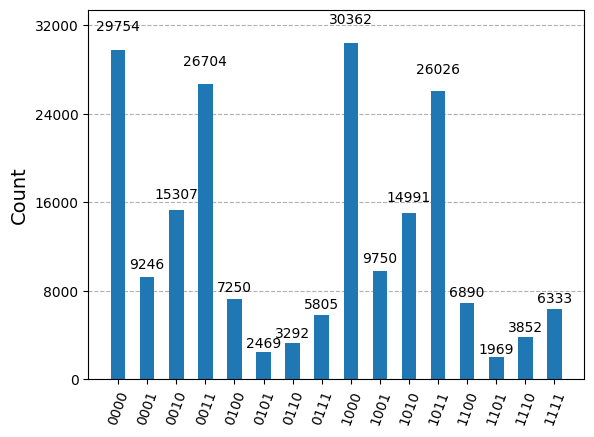

In [19]:
plot_histogram(english_results[0].get_counts(english_qiskit_circuits[0]))

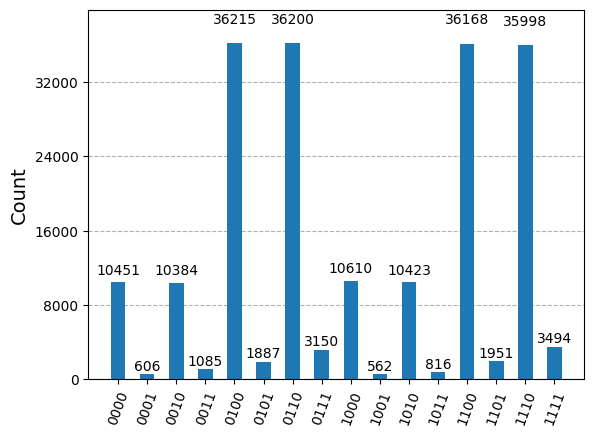

In [20]:
plot_histogram(randomized_results[0].get_counts(randomized_qiskit_circuits[0]))

In [21]:
def entropy_function(counts : List[int]) -> int:
    count_array = np.array(counts)
    total = np.sum(count_array)
    probability = count_array / total
    return -np.sum(probability * np.log2(probability))

In [22]:
entropy_function(list(english_results[0].get_counts(english_qiskit_circuits[0]).values()))

np.float64(3.571963689108707)

In [23]:
entropy_function(list(randomized_results[0].get_counts(randomized_qiskit_circuits[0]).values()))

np.float64(3.1225136220867835)

In [24]:
spanish_entropies = []
english_entropies = []
randomized_entropies = []
for result_index, spanish_result in enumerate(spanish_results):
    english_result = english_results[result_index]
    randomized_result = randomized_results[result_index]

    spanish_entropies.append(entropy_function(list(spanish_result.get_counts(spanish_qiskit_circuits[result_index]).values())))
    english_entropies.append(entropy_function(list(english_result.get_counts(english_qiskit_circuits[result_index]).values())))
    randomized_entropies.append(entropy_function(list(randomized_result.get_counts(randomized_qiskit_circuits[result_index]).values())))

In [25]:
import matplotlib.pyplot as plt

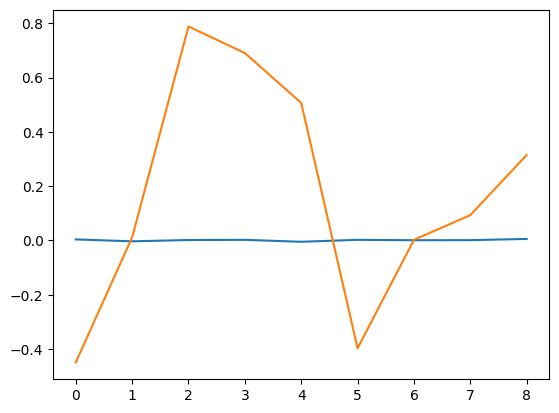

In [26]:
plt.plot(np.array(spanish_entropies) - np.array(english_entropies))
plt.plot(np.array(randomized_entropies) - np.array(english_entropies))